# A notebook to test the ABM of tumoral growth. 
We can manually define a fitness landscape or use OncoSimulR to generate a random one for us.

In [4]:
#We import the common functions and model.
include("./functions.jl")

In this cell we define all the parameters and run the simulation

In [5]:

fitness=Dict([0,0,0]=>1, #Fitness of each of the genotypes, the key is the binary representation of the genotype in decimal form.
            [1,0,0]=>1.3,
            [0,1,0]=>1.2,
            [1,1,0]=>1.5,
            [1,1,1]=>1.2)

#OncoSimulR integration! We can use the rfitness function to generate random fitness landscapes
#fitness=OncoSimulR_rfitness(g=3,c=0.5,sd=1) 

#We load a scenario from an image
#scenario = get_2D_scenario_from_bmp("./scenarios/example2.bmp") #I have added some examples (1 to 4) and some templates.

#We define the scenario, we can specify the number of cells or the positions of cells.
#Some examples:
# 0D_scenario = create_scenario(1000,10,"random")
# 1D_scenario = create_scenario((1000,),50,"center")
# 2D_scenario = create_scenario((100,100),[(10,10),(20,40),(80,10)])
# 3D_scenario = create_scenario((100,100,100),50,"random")

scenario = create_scenario((1000000,),10)

#We define a Treatment
#I need to include the posibility of making it time-dependent instead of tumor size-dependent.
adaptive_therapy = Treatment(3000, #Detecting size
                            2000, #Starting size: treatment will start when this cell_count is reached
                            1000, #Pausing size: treatment will stop when this cell_count is reached
                            3, #Gene of resistance
                            0.75, #Kill rate
                            false, #Initial state of the treatment
                            false) #Initial detection of the treatment 

continuous_therapy = Treatment(3000, #Detecting size
                            2000, #Starting size: treatment will start when this cell_count is reached
                            1000, #Pausing size: treatment will stop when this cell_count is reached
                            3, #Gene of resistance
                            0.75, #Kill rate
                            false, #Initial state of the treatment
                            false) #Initial detection of the treatment 

#We initialize the model.
model = model_init(pr=0.027, #Proliferation rate
                    dr=0.015, #Death rate
                    mr=0.01, #Mutation rate
                    scenario=scenario, #The scenario
                    fitness=fitness, #The fitness of each genotype
                    treatment=adaptive_therapy, #The treatment we are going to use for the simulation
                    seed=0) #Seed to get reproducible results

println(model)

#we collect the number of cells of each genotype that are alive
agent_collect = [(:genotype, f) for f in genotype_fraction_function_generator(fitness)]
model_collect = [:current_size]
#we run the simulation
steps= 10

adata, mdata = run!(model, agent_step!, model_step!, steps; adata = agent_collect, mdata=model_collect)

#we rename the columns to get a clean "data" DataFrame.
genotypes = [replace(string(x)," "=>"") for x in sort!([x for x in keys(fitness)],by=x -> bit_2_int(BitArray(x)))]
pushfirst!(genotypes,"step")
rename!(adata,genotypes)

Paramscan: Make combinations of diferent parameters automatically

In [147]:

parameters = Dict(
    :pr => 0.027,
    :dr => 0.015,
    :mr => 0.01,
    :scenario => scenario,
    :fitness => fitness,
    :treatment => [adaptive_therapy,continuous_therapy],
    :seed => 0
)

adata, _ = paramscan(parameters, model_init; adata = agent_collect, mdata = model_collect, agent_step! = agent_step!, model_step! = model_step!, n = 1700)

#we rename the columns to get a clean "data" DataFrame.
genotypes = [replace(string(x)," "=>"") for x in sort!([x for x in keys(fitness)],by=x -> bit_2_int(BitArray(x)))]
pushfirst!(genotypes,"step")
#We need to push the parameters we scan
push!(genotypes,"treatment")
rename!(adata,genotypes)

Row,step,"[0,0,0]","[0,1,0]","[1,0,0]","[1,1,0]","[1,1,1]",treatment
,Int64,Int64,Int64,Int64,Int64,Int64,Treatment
1,0,10,0,0,0,0,"Treatment(3000, 2000, 1000, 3, 0.75, true, true)"
2,1,11,0,0,0,0,"Treatment(3000, 2000, 1000, 3, 0.75, true, true)"
3,2,11,0,0,0,0,"Treatment(3000, 2000, 1000, 3, 0.75, true, true)"
4,3,11,0,0,0,0,"Treatment(3000, 2000, 1000, 3, 0.75, true, true)"
5,4,11,0,0,0,0,"Treatment(3000, 2000, 1000, 3, 0.75, true, true)"
6,5,11,0,0,0,0,"Treatment(3000, 2000, 1000, 3, 0.75, true, true)"
7,6,10,0,0,0,0,"Treatment(3000, 2000, 1000, 3, 0.75, true, true)"
8,7,11,0,0,0,0,"Treatment(3000, 2000, 1000, 3, 0.75, true, true)"
9,8,11,0,0,0,0,"Treatment(3000, 2000, 1000, 3, 0.75, true, true)"


From this point we are just plotting and analising the data we generated

In [98]:
#We plot the "density" of each space in the grid: The number of cells there are in that space.

#Functions to get a color gradient of density
densitycolor(a) = get(colorschemes[:matter], a.near_cells, (1,5))
densitycolor_legend(a) = get(colorschemes[:matter], a, (1,5))

#Right now we plot the walls as a heatarray because its te easiest thing i found to just get it working.
#heatarray = :wall_matrix
#heatkwargs = (colorrange = (0, 1), colormap = :grayC)

#We plot the density
figure,ax = abmplot(model;ac = densitycolor,as=0.5)

#We add a legend
Legend(figure[1, 2],
    [MarkerElement(color = densitycolor_legend(a), marker = '■', markersize = 15, strokecolor = :black) for a in 1:5],
    [string(x) for x in 1:5],
    patchsize = (20, 20), rowgap = 1)

#We display the figure
figure

In [113]:
#We plot the genotype of each cell with a different color.
genotypes = [replace(string(x)," "=>"") for x in sort!([x for x in keys(fitness)],by=x -> bit_2_int(BitArray(x)))]
genotype_bits = [x for x in sort!([x for x in keys(fitness)],by=x -> bit_2_int(BitArray(x)))]
order = Dict(zip(genotype_bits,1:length(genotype_bits)))

#Functions to get a different color for each genotype
genotypecolor(a) = get(colorschemes[:hsv], order[a.genotype], (1,length(genotypes)+1))
genotypecolor_legend(a) = get(colorschemes[:hsv], a, (1,length(genotypes)+1))

#We make a static plot
#figure, _ = abmplot(model;ac = genotypecolor,as=8,am='■',heatarray,heatkwargs)

#We make a dynamic plot
figure, _ = abmplot(model;agent_step! = agent_step!,model_step! = model_step!,ac = genotypecolor,as=0.5)


#We create a legend for the genotypes
Legend(figure[1, 2],
    [MarkerElement(color = genotypecolor_legend(a), marker = '■', markersize = 15, strokecolor = :black) for a in 1:length(genotypes)],
    genotypes,
    patchsize = (20, 20), rowgap = 1)


#We display the figure
figure

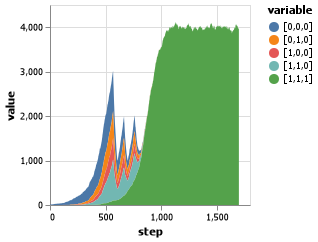

In [142]:
#And lastly we can make plots of both the total number of cells of each genotype
genotypes = [replace(string(x)," "=>"") for x in sort!([x for x in keys(fitness)],by=x -> bit_2_int(BitArray(x)))]
stacked = stack(adata,genotypes)

stacked |>
@vlplot(:area, x=:step, y={:value, stack=:zero}, color="variable:n")

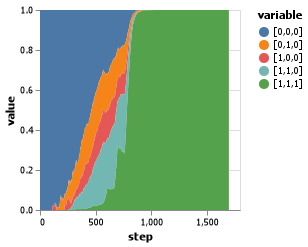

In [143]:
#And the relative number of cells of each genotype
stacked |>
@vlplot(:area, x=:step, y={:value, stack=:normalize}, color="variable:n")

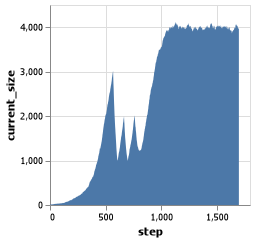

In [141]:
#We plot the number of total cells
mdata |>
@vlplot(:area, x=:step, y=:current_size)

In [146]:
#We save the simulation data
CSV.write("./results/adata_1.csv",adata)
CSV.write("./results/mdata_1.csv",mdata)

"./results/mdata_1.csv"